## 🧭 Path Planning with Potential Fields and Elliptical Obstacles
This notebook demonstrates a potential field path planning algorithm with elliptical obstacles in a 2D workspace.

### 1. Workspace Setup with Elliptical Obstacles

*We define a 10x10 workspace with a start point at (1,1) and a goal point at (8,8). Five elliptical obstacles are randomly generated with varying sizes and orientations.*

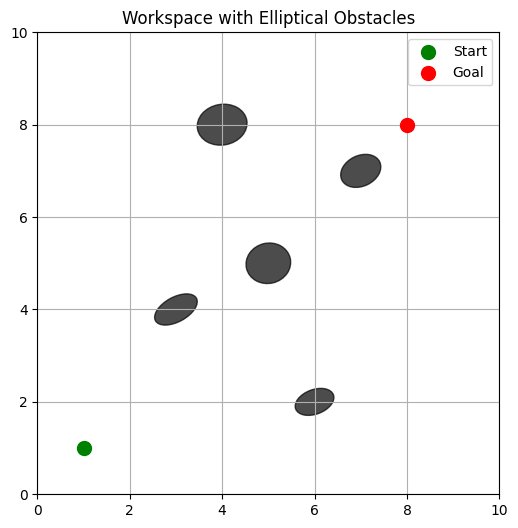

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import random

# Workspace parameters
workspace_size = (10, 10)
start = (1, 1)
goal = (8, 8)

# Generate random elliptical obstacles
obstacles = [
    (3, 4, random.uniform(0.8, 1.5), random.uniform(0.5, 1.2), random.uniform(0, 180)),
    (5, 5, random.uniform(0.8, 1.5), random.uniform(0.5, 1.2), random.uniform(0, 180)),
    (6, 2, random.uniform(0.8, 1.5), random.uniform(0.5, 1.2), random.uniform(0, 180)),
    (7, 7, random.uniform(0.8, 1.5), random.uniform(0.5, 1.2), random.uniform(0, 180)),
    (4, 8, random.uniform(0.8, 1.5), random.uniform(0.5, 1.2), random.uniform(0, 180))
]

# Plot the workspace
plt.figure(figsize=(8, 6))
plt.scatter(*start, color='green', s=100, label='Start', zorder=5)
plt.scatter(*goal, color='red', s=100, label='Goal', zorder=5)
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.grid(True)
plt.title('Workspace with Elliptical Obstacles')
plt.legend()
plt.xlim(0, workspace_size[0])
plt.ylim(0, workspace_size[1])
plt.gca().set_aspect('equal')
plt.show()

### 2. Potential Field Calculation

*We compute the attractive potential pulling the robot towards the goal and the repulsive potential pushing it away from obstacles. The total potential is the sum of both.*

In [42]:
from scipy import ndimage

def attractive_potential(x, y, goal, k_att=0.5):
    return 0.5 * k_att * ((x - goal[0])**2 + (y - goal[1])**2)

def repulsive_potential(x, y, obstacles, k_rep=100, influence_scale=1.5):
    rep = 0
    for obs in obstacles:
        ox, oy, w, h, angle = obs
        angle_rad = np.deg2rad(angle)
        dx = x - ox
        dy = y - oy
        x_rot = dx * np.cos(angle_rad) + dy * np.sin(angle_rad)
        y_rot = -dx * np.sin(angle_rad) + dy * np.cos(angle_rad)
        effective_dist = np.sqrt((x_rot/(w/2))**2 + (y_rot/(h/2))**2)
        d0 = influence_scale
        if effective_dist <= d0:
            rep += 0.5 * k_rep * (1/max(effective_dist, 0.1) - 1/d0)**2 * (d0 - effective_dist)
    return rep

x = np.linspace(0, workspace_size[0], 100)
y = np.linspace(0, workspace_size[1], 100)
X, Y = np.meshgrid(x, y)

Z_att = attractive_potential(X, Y, goal)
Z_rep = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z_rep[j, i] = repulsive_potential(x[i], y[j], obstacles)
Z_total = Z_att + Z_rep

### 3. Visualizing Potential Fields

*We visualize the attractive, repulsive, and total potential fields to understand how the robot perceives the environment.*

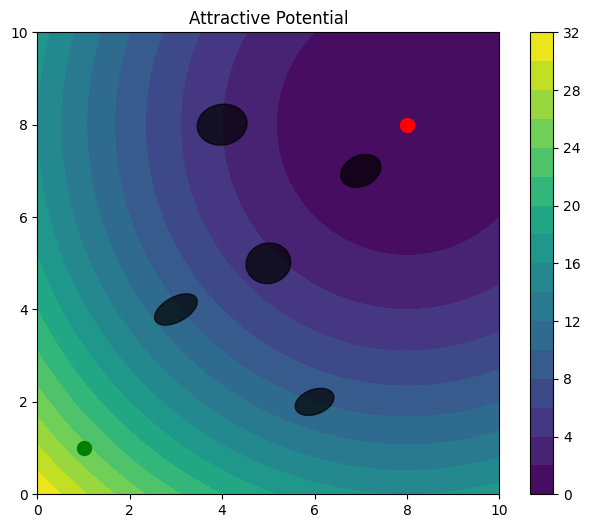

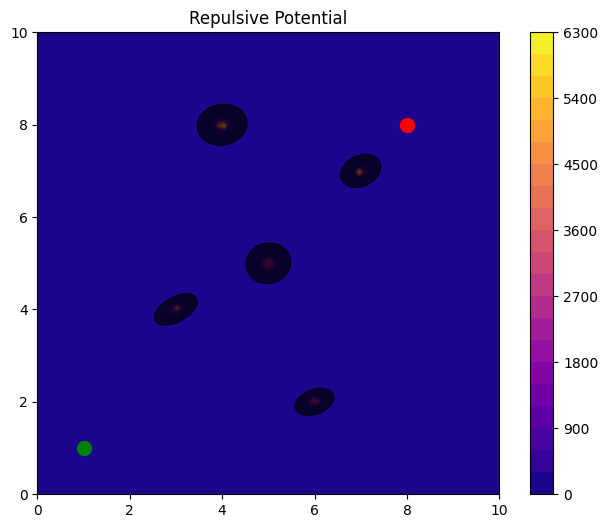

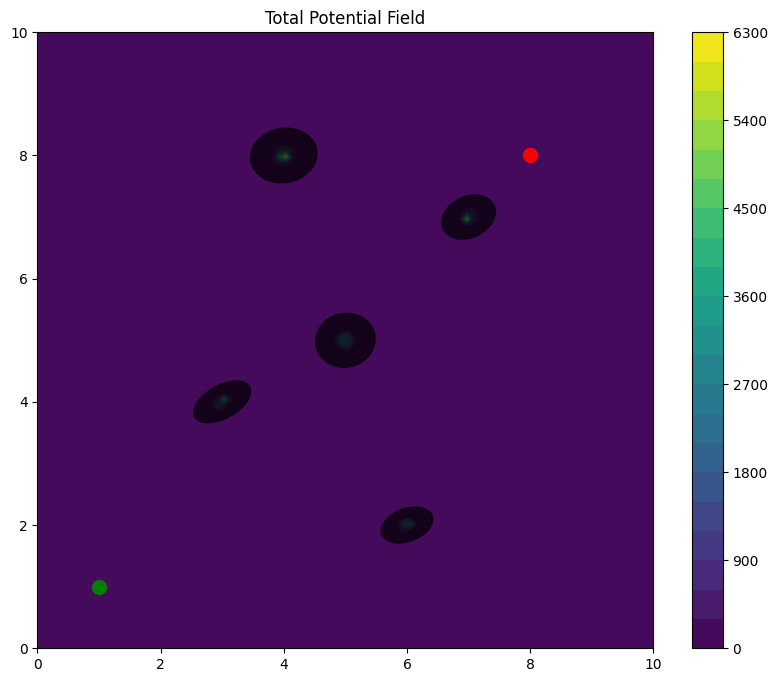

In [43]:
# Attractive
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z_att, 20, cmap='viridis')
plt.colorbar()
plt.scatter(*start, color='green', s=100)
plt.scatter(*goal, color='red', s=100)
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.title('Attractive Potential')
plt.gca().set_aspect('equal')
plt.show()

# Repulsive
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z_rep, 20, cmap='plasma')
plt.colorbar()
plt.scatter(*start, color='green', s=100)
plt.scatter(*goal, color='red', s=100)
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.title('Repulsive Potential')
plt.gca().set_aspect('equal')
plt.show()

# Total
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z_total, 20, cmap='viridis')
plt.colorbar()
plt.scatter(*start, color='green', s=100)
plt.scatter(*goal, color='red', s=100)
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.title('Total Potential Field')
plt.gca().set_aspect('equal')
plt.show()

### 4. Gradient Calculation

*We compute the gradient of the total potential field, which indicates the direction of the steepest ascent. The robot will follow the negative gradient to move towards the goal.*

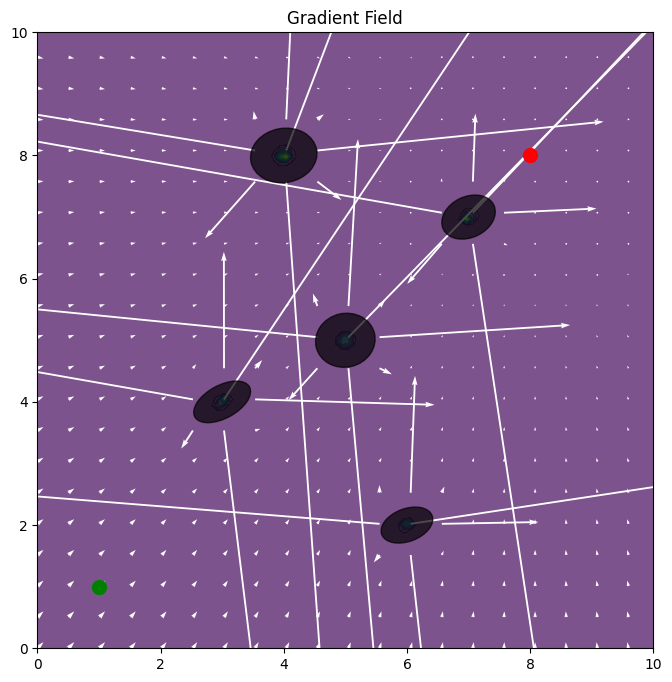

In [44]:
gy, gx = np.gradient(Z_total)
gx = ndimage.gaussian_filter(gx, sigma=1.5)
gy = ndimage.gaussian_filter(gy, sigma=1.5)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z_total, 20, cmap='viridis', alpha=0.7)
plt.quiver(X[::5, ::5], Y[::5, ::5], -gx[::5, ::5], -gy[::5, ::5],
           scale=40, color='white')
plt.scatter(*start, color='green', s=100)
plt.scatter(*goal, color='red', s=100)
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.title('Gradient Field')
plt.gca().set_aspect('equal')
plt.show()

### 5. Path Planning

*Using the negative gradient, we simulate the robot's movement from the start to the goal, avoiding obstacles.*

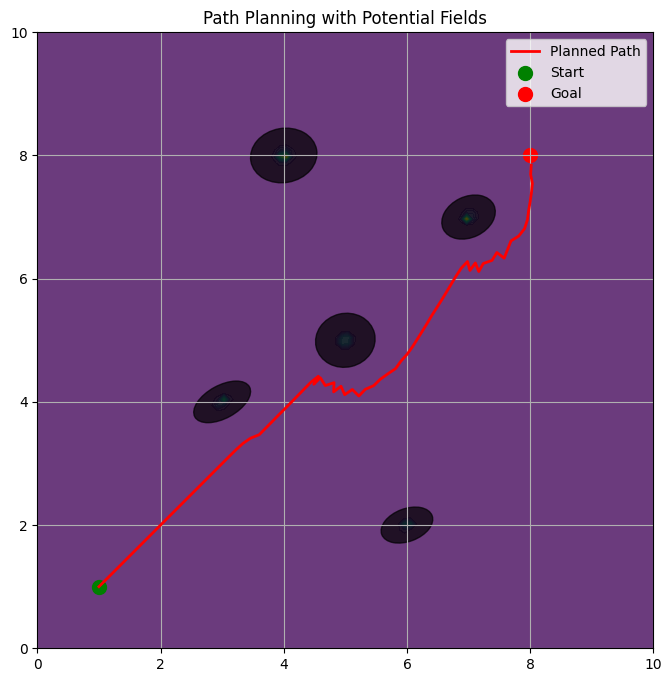

In [45]:
def find_path(start, goal, obstacles, max_iters=1000, step_size=0.15):
    path = [np.array(start)]
    current = np.array(start, dtype=float)

    for _ in range(max_iters):
        collision = False
        for obs in obstacles:
            ox, oy, w, h, angle = obs
            angle_rad = np.deg2rad(angle)
            dx = current[0] - ox
            dy = current[1] - oy
            x_rot = dx * np.cos(angle_rad) + dy * np.sin(angle_rad)
            y_rot = -dx * np.sin(angle_rad) + dy * np.cos(angle_rad)
            effective_dist = (x_rot/(w/2))**2 + (y_rot/(h/2))**2

            if effective_dist <= 1.0:
                escape_dir = current - np.array([ox, oy])
                escape_dir = escape_dir/np.linalg.norm(escape_dir)
                current += 0.3 * escape_dir
                collision = True
                break

        if not collision:
            idx_x = np.argmin(np.abs(x - current[0]))
            idx_y = np.argmin(np.abs(y - current[1]))
            dx = -gx[idx_y, idx_x]
            dy = -gy[idx_y, idx_x]
            norm = np.sqrt(dx**2 + dy**2)
            if norm > 0:
                current += step_size * np.array([dx/norm, dy/norm])

        path.append(current.copy())
        if np.linalg.norm(current - goal) < 0.3:
            break

    return np.array(path)

# Execute
path = find_path(start, goal, obstacles)

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z_total, 20, cmap='viridis', alpha=0.8)
plt.plot(path[:, 0], path[:, 1], 'r-', linewidth=2, label='Planned Path')
plt.scatter(*start, color='green', s=100, label='Start')
plt.scatter(*goal, color='red', s=100, label='Goal')
for obs in obstacles:
    ellipse = patches.Ellipse((obs[0], obs[1]), obs[2], obs[3], angle=obs[4],
                              color='black', alpha=0.7)
    plt.gca().add_patch(ellipse)
plt.legend()
plt.title('Path Planning with Potential Fields')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

### 6. 3D Visualization of Total Potential Field

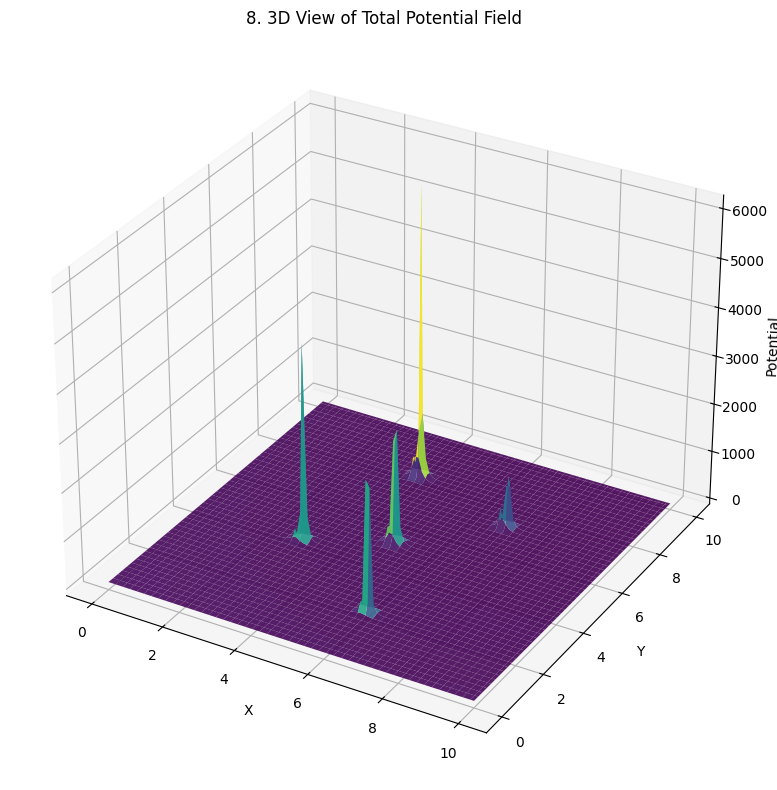

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title('8. 3D View of Total Potential Field')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
plt.tight_layout()
plt.show()


### 7. Visualization of Final Path on Potential Field

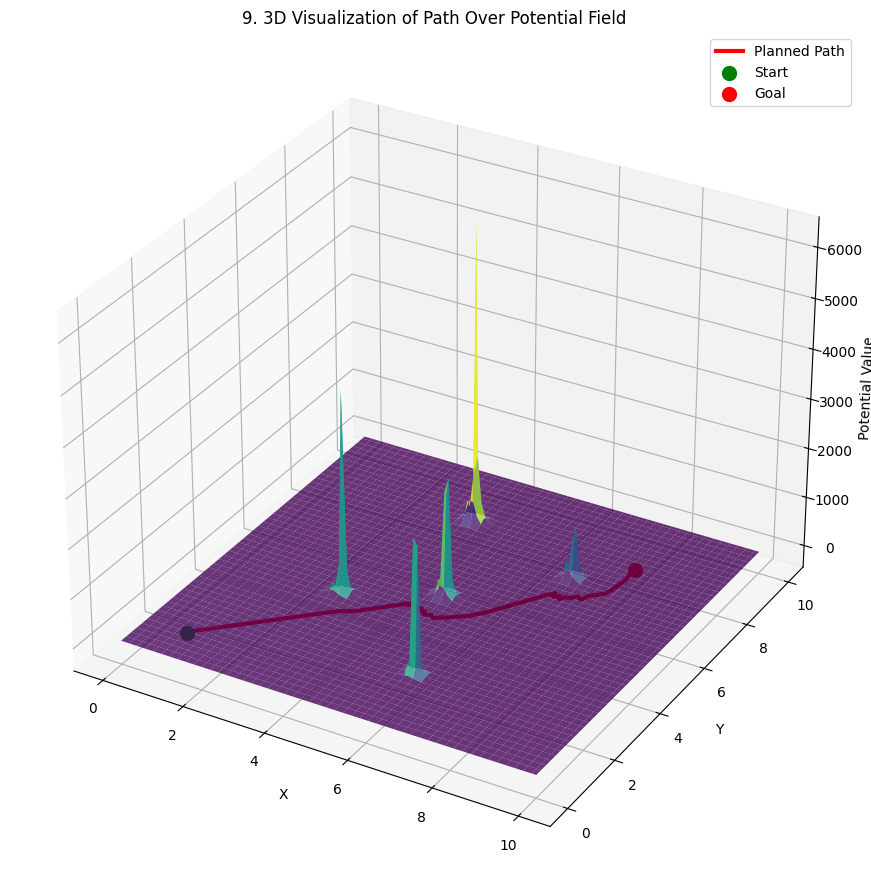

In [47]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Surface plot of the potential field
ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none', alpha=0.8)

# Path elevation based on potential
path_z = [attractive_potential(px, py, goal) + repulsive_potential(px, py, obstacles) for px, py in path]
ax.plot(path[:, 0], path[:, 1], path_z, color='red', linewidth=3, label='Planned Path')

# Start and Goal markers
ax.scatter(start[0], start[1], 0, color='green', s=100, label='Start')
ax.scatter(goal[0], goal[1], 0, color='red', s=100, label='Goal')

ax.set_title('9. 3D Visualization of Path Over Potential Field')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential Value')
ax.legend()
plt.tight_layout()
plt.show()


### 8. Conclusion

In [48]:
print("""
Conclusion:

The potential field-based path planning algorithm effectively guides the robot from the start to the goal location
while avoiding elliptical obstacles. Attractive potentials pull the robot toward the goal, and repulsive potentials
push it away from obstacles. Gradient descent on the total potential guides the motion, and an escape mechanism
helps the robot navigate out of obstacle collisions. The method works well in known static environments with smooth terrain.
""")


Conclusion:

The potential field-based path planning algorithm effectively guides the robot from the start to the goal location
while avoiding elliptical obstacles. Attractive potentials pull the robot toward the goal, and repulsive potentials
push it away from obstacles. Gradient descent on the total potential guides the motion, and an escape mechanism
helps the robot navigate out of obstacle collisions. The method works well in known static environments with smooth terrain.

